Estrategias Evolutivas
===

* 30:00 min | Última modificación: Mayo 19, 2021 | [YouTube]

In [1]:
import math
import random
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np

## Función a optimizar

In [2]:
#
# Función de Rosenbrock con:
#
#     -2.048 <= x0 <= 2.048
#       -1.0 <= x1 <= 4.0
#
def fn(x):
    return 100 * (x[0] ** 2 - x[1]) ** 2 + (1 - x[0]) ** 2

## Algoritmo evolutivo básico para Estrategias Evolutivas

```python
# Genera una población aleatoria de soluciones
population = GeneratePopulation()

# Evalua la función a optimizar para cada
# miembro de la poblacion
population = fn_eval(population)

for i in range(NGEN):

    # Selecciona los padres aleatoriamente
    p1, p2 = get_parents(population)
    
    # realiza el cruce entre padres
    offsprings = crossover(population, p1, p2)
    
    # muta los hijos
    offsprings = mutate(offsprings)
    
    # evalua la función a optimizar para cada
    # uno de los hijos
    offsprings = fn_eval(offsprings)
    
    if STRATEGY == "+":
        # Se seleccionan los mejores individuos entre
        # padres e hijos
        population = population + offsprings
    
    if STRATEGY == ",":
        # Selecciona los mejores individuos solo
        # entre los hijos
        population = offsprings
    
    # Obtiene la siguiente población
    population = selection(population)
``` 

## Estructura basica para representar los individuos

In [17]:
%%writefile individual.py

class Individual(dict):
    #
    # Este es básicamente un diccionario cuyas
    # claves pueden accederse como propiedades
    #
    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

Writing individual.py


## Inicialización

In [4]:
#
# Genera una población inicial aleatoria
# con valores uniformemente distribuidos
#
class RandomPopulation:
    def __init__(self, pop_size, low, high, sigma=None, sigmas=None):
        self.pop_size = pop_size
        self.low = low
        self.high = high
        self.sigma = sigma
        self.sigmas = sigmas

    def __call__(self):
        #
        #
        #
        population = [
            Individual(
                {
                    "x": np.random.uniform(low=self.low, high=self.high),
                    "fn_x": None,
                }
            )
            for _ in range(self.pop_size)
        ]

        #
        #
        #
        if self.sigma is not None:
            for individual in population:
                individual["sigma"] = self.sigma

        #
        #
        #
        if self.sigmas is not None:
            if isinstance(self.sigmas, (int, float)):
                n_dim = len(self.low)
                self.sigmas = np.array([self.sigmas] * n_dim)
            for individual in population:
                individual["sigmas"] = np.array(self.sigmas)

        return population


#
# Genera la población inicial
#
POPSIZE = 10  # tamaño de la poblacion

population = RandomPopulation(
    pop_size=POPSIZE,
    low=[-2.048, -1.0, -5.0],
    high=[2.048, +4.0, +5.0],
    sigma=0.5,
)()

population

[{'x': array([1.88393812e+00, 4.49353294e-04, 1.33058609e-01]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.50012395, -0.40147298, -4.80266088]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.68359176,  3.57634113,  0.52231249]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-0.23963692,  3.14102804, -3.07193863]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.54319795,  1.18474335, -1.383377  ]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.62653884,  0.66154558, -4.56562639]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.21295121, -0.89349037,  0.64229867]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.51880945, -0.51355378, -0.45917343]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 0.58568804, -0.28597984,  2.28129615]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.10467471,  3.07773717, -1.46230753]),
  'fn_x': None,
  'sigma': 0.5}]

## Selección de padres

In [5]:
class SelectionUniform:
    #
    # Todos los individuos tienen la misma probabilidad
    #  de ser seleccionados como padres
    #
    def __init__(self, n_parents):
        self.n_parents = n_parents

    def __call__(self, population):
        index = list(range(len(population)))
        parent1 = random.choices(index, k=self.n_parents)
        parent2 = random.choices(index, k=self.n_parents)
        return parent1, parent2


#
# Se generan NOFFSPRINGS hijos. Se seleccionan
# los dos padres de cada individuo
#
NOFFSPRINGS = 15

#
# Define el operador de selección de padres
#
parent_selection = SelectionUniform(n_parents=NOFFSPRINGS)

#
# Selecciona los padres de la siguiente generacion
#
p1, p2 = parent_selection(population)
p1, p2

([2, 5, 4, 3, 5, 1, 4, 5, 8, 2, 9, 9, 7, 9, 7],
 [4, 0, 7, 6, 9, 6, 4, 5, 9, 2, 8, 9, 9, 6, 7])

## Cruce

In [6]:
class CrossoverDiscrete:
    def __call__(self, population, parent1, parent2):

        n_dim = len(population[0].x)
        n_offsprings = len(parent1)

        rand = [
            np.random.uniform(low=[0.0] * n_dim, high=[1.0] * n_dim)
            for _ in range(len(parent1))
        ]

        offsprings = [
            Individual(
                {
                    "x": np.where(rnd > 0.5, population[p2].x, population[p1].x),
                    "fn_x": None,
                }
            )
            for rnd, p1, p2 in zip(rand, parent1, parent2)
        ]

        if "sigma" in population[0].keys():
            for idx, offspring in enumerate(offsprings):

                p1 = parent1[idx]
                p2 = parent2[idx]

                if np.random.uniform() < 0.5:
                    offspring.sigma = population[p1].sigma
                else:
                    offspring.sigma = population[p2].sigma

        if "sigmas" in population[0].keys():

            for offspring, p1, p2 in zip(offsprings, parent1, parent2):

                random_uniform = np.random.uniform(
                    low=[0.0] * n_dim, high=[1.0] * n_dim
                )
                offspring.sigmas = np.where(
                    random_uniform < 0.5, population[p1].sigmas, population[p2].sigmas
                )

        return offsprings


#
# Define el operador de cruce
#
crossover = CrossoverDiscrete()

#
# Genera los hijos mediante el cruce de padres
#
offsprings = crossover(population, p1, p2)
offsprings

[{'x': array([-1.54319795,  1.18474335, -1.383377  ]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([1.88393812e+00, 4.49353294e-04, 1.33058609e-01]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.51880945,  1.18474335, -1.383377  ]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-0.23963692, -0.89349037,  0.64229867]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.62653884,  3.07773717, -1.46230753]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.21295121, -0.89349037, -4.80266088]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.54319795,  1.18474335, -1.383377  ]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 1.62653884,  0.66154558, -4.56562639]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([ 0.58568804, -0.28597984,  2.28129615]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.68359176,  3.57634113,  0.52231249]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.10467471,  3.07773717,  2.28129615]),
  'fn_x': None,
  'sigma': 0.5},
 {'x': array([-1.104674

## Mutación

In [7]:
class MutateGaussianES:
    def __call__(self, population):

        #
        # Número de dimensiones
        #
        n_dim = len(population[0].x)

        #
        # Constante definida por el algoritmo
        #
        tau = 1.0 / np.power(2.0, 1.0 / n_dim)

        for individual in population:

            if "sigma" in individual.keys():

                #
                # Muta el sigma del individuo
                #
                individual.sigma = individual.sigma * np.exp(tau * np.random.normal())

                #
                # Muta las x con el nuevo sigma
                #
                individual.x = individual.x + individual.sigma * np.random.normal(
                    size=n_dim
                )

            if "sigmas" in individual.keys():

                #
                # Muta el sigma del individuo
                #
                individual.sigmas = individual.sigmas * np.exp(
                    tau * np.random.normal(n_dim)
                )

                #
                # Muta las x con el nuevo sigma
                #
                individual.x = individual.x + individual.sigmas * np.random.normal(
                    size=n_dim
                )

        return population


#
# Define el operador de mutación
#
mutate = MutateGaussianES()

#
# Muta la población de hijos
#
offsprings = mutate(offsprings)
offsprings

[{'x': array([-1.40066363,  1.46539014, -1.74224795]),
  'fn_x': None,
  'sigma': 0.85440835563215},
 {'x': array([ 1.76051332,  2.03509321, -0.27340056]),
  'fn_x': None,
  'sigma': 0.6429936252468751},
 {'x': array([ 1.35669079,  0.86635224, -1.06536246]),
  'fn_x': None,
  'sigma': 0.26266779716582456},
 {'x': array([-0.62848733, -0.33747228,  0.61218453]),
  'fn_x': None,
  'sigma': 0.3231067785581017},
 {'x': array([ 0.91252461,  3.52502115, -1.57650899]),
  'fn_x': None,
  'sigma': 0.7055711594935418},
 {'x': array([ 6.13517605, -2.365662  , -1.68200453]),
  'fn_x': None,
  'sigma': 2.863418719840632},
 {'x': array([-0.57469168,  1.79277902, -1.49761624]),
  'fn_x': None,
  'sigma': 1.5076368787726941},
 {'x': array([ 2.02630424,  1.53703461, -5.47824362]),
  'fn_x': None,
  'sigma': 1.1544857917160973},
 {'x': array([0.90306732, 0.5530002 , 2.13843465]),
  'fn_x': None,
  'sigma': 0.38745325071051917},
 {'x': array([-1.82537092,  4.1703904 , -0.20164071]),
  'fn_x': None,
  'sig

## Evaluación de la función objetivo

In [8]:
class FnEval:
    def __init__(self, fn):
        self.fn = fn

    def __call__(self, pop):
        #
        # Evalua la función objetivo
        #
        for individual in pop:
            if individual.fn_x is None:
                individual.fn_x = self.fn(individual.x)

        return pop


#
# Define el operador para la evaluación
#
fn_eval = FnEval(fn=fn)

#
# Evalua la función objetivo para los hijos
#
offsprings = fn_eval(offsprings)
offsprings

[{'x': array([-1.40066363,  1.46539014, -1.74224795]),
  'fn_x': 30.41128066802604,
  'sigma': 0.85440835563215},
 {'x': array([ 1.76051332,  2.03509321, -0.27340056]),
  'fn_x': 113.85479953116483,
  'sigma': 0.6429936252468751},
 {'x': array([ 1.35669079,  0.86635224, -1.06536246]),
  'fn_x': 95.04502520661251,
  'sigma': 0.26266779716582456},
 {'x': array([-0.62848733, -0.33747228,  0.61218453]),
  'fn_x': 56.30299685225688,
  'sigma': 0.3231067785581017},
 {'x': array([ 0.91252461,  3.52502115, -1.57650899]),
  'fn_x': 724.8663439285507,
  'sigma': 0.7055711594935418},
 {'x': array([ 6.13517605, -2.365662  , -1.68200453]),
  'fn_x': 160074.75086340803,
  'sigma': 2.863418719840632},
 {'x': array([-0.57469168,  1.79277902, -1.49761624]),
  'fn_x': 216.3727646410446,
  'sigma': 1.5076368787726941},
 {'x': array([ 2.02630424,  1.53703461, -5.47824362]),
  'fn_x': 660.9647953571774,
  'sigma': 1.1544857917160973},
 {'x': array([0.90306732, 0.5530002 , 2.13843465]),
  'fn_x': 6.90161619

## Selección de la próxima generación

In [9]:


#
# Define el operador
#
selection = SelectionBest(k=POPSIZE)

#
# Selecciona los mejores k individuos
#
population = selection(offsprings)
population

[{'x': array([ 0.23029261, -0.13993862, -1.05822233]),
  'fn_x': 4.316319221569982,
  'sigma': 1.1120739648197195},
 {'x': array([0.90306732, 0.5530002 , 2.13843465]),
  'fn_x': 6.901616199464699,
  'sigma': 0.38745325071051917},
 {'x': array([-1.40066363,  1.46539014, -1.74224795]),
  'fn_x': 30.41128066802604,
  'sigma': 0.85440835563215},
 {'x': array([-0.62848733, -0.33747228,  0.61218453]),
  'fn_x': 56.30299685225688,
  'sigma': 0.3231067785581017},
 {'x': array([-1.82537092,  4.1703904 , -0.20164071]),
  'fn_x': 78.27608680374402,
  'sigma': 0.3965000501420965},
 {'x': array([ 1.35669079,  0.86635224, -1.06536246]),
  'fn_x': 95.04502520661251,
  'sigma': 0.26266779716582456},
 {'x': array([ 1.76051332,  2.03509321, -0.27340056]),
  'fn_x': 113.85479953116483,
  'sigma': 0.6429936252468751},
 {'x': array([ 1.16117451,  2.52930869, -1.08669383]),
  'fn_x': 139.49793137506734,
  'sigma': 0.9034862496840742},
 {'x': array([-1.19372283,  2.60641194, -2.50258583]),
  'fn_x': 144.3919

## Algoritmo Básico --- Estrategias de Evolución

In [10]:
def compute_history(history, population):
    history["max"].append(population[-1].fn_x)
    history["min"].append(population[0].fn_x)
    history["mean"].append(np.mean([individual.fn_x for individual in population]))
    return history

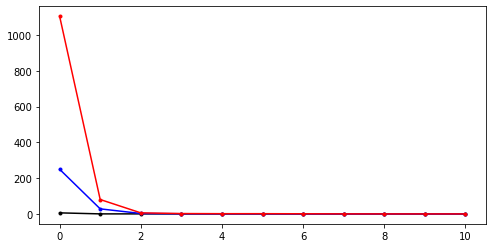

In [11]:
#
# EE con un sigma
# =======================================================================
#

#
# Parámetros
#
NGEN = 10
POPSIZE = 6
NOFFSPRINGS = 15
STRATEGY = "+"


#
# Operadores genéticos
# =======================================================================
#

# Poblacion inicial
generate_population = RandomPopulation(
    pop_size=POPSIZE,
    low=[-2.048, -1.0, -5.0],
    high=[2.048, +4.0, +5.0],
    sigma=0.5,
)

# Selección de padres
get_parents = SelectionUniform(n_parents=NOFFSPRINGS)

# Cruce
crossover = CrossoverDiscrete()

# Mutación
mutate = MutateGaussianES()

# Evaluación de la función objetivo
fn_eval = FnEval(fn)

# selección de la siguiente generacion
selection = SelectionBest(k=POPSIZE)


#
# Algoritmo
# =======================================================================
#

# Se genera la población inicial
population = generate_population()

# Se evalua la función objetivo de la
# población inicial
population = fn_eval(population)

# historia
history = {"max": [], "min": [], "mean": []}

# ordena la poblacion
population = selection(population)

# Computa las estadísiticas de la población
history = compute_history(history, population)


for _ in range(NGEN):

    p1, p2 = get_parents(population)

    offsprings = crossover(population, p1, p2)

    offsprings = mutate(offsprings)

    offsprings = fn_eval(offsprings)

    if STRATEGY == "+":
        population = population + offsprings
    if STRATEGY == ",":
        population = offsprings

    population = selection(population)

    history = compute_history(history, population)


plt.figure(figsize=(8, 4))
plt.plot(history["min"], ".-k")
plt.plot(history["mean"], ".-b")
plt.plot(history["max"], ".-r")
plt.show()

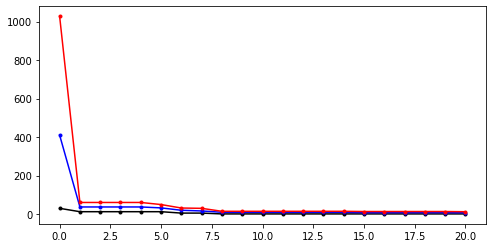

In [12]:
#
# EE con varios sigmas
# =======================================================================
#

#
# Parámetros
#
NGEN = 20
POPSIZE = 6
NOFFSPRINGS = 15
STRATEGY = "+"


#
# Operadores genéticos
# =======================================================================
#

# Poblacion inicial
generate_population = RandomPopulation(
    pop_size=POPSIZE,
    low=[-2.048, -1.0, -5.0],
    high=[2.048, +4.0, +5.0],
    sigmas=0.1,
)

# Selección de padres
get_parents = SelectionUniform(n_parents=NOFFSPRINGS)

# Cruce
crossover = CrossoverDiscrete()

# Mutación
mutate = MutateGaussianES()

# Evaluación de la función objetivo
fn_eval = FnEval(fn)

# selección de la siguiente generacion
selection = SelectionBest(k=POPSIZE)


#
# Algoritmo
# =======================================================================
#

# Se genera la población inicial
population = generate_population()

# Se evalua la función objetivo de la
# población inicial
population = fn_eval(population)

# historia
history = {"max": [], "min": [], "mean": []}

# ordena la poblacion
population = selection(population)

# Computa las estadísiticas de la población
history = compute_history(history, population)


for _ in range(NGEN):

    p1, p2 = get_parents(population)

    offsprings = crossover(population, p1, p2)

    offsprings = mutate(offsprings)

    offsprings = fn_eval(offsprings)

    if STRATEGY == "+":
        population = population + offsprings
    if STRATEGY == ",":
        population = offsprings

    population = selection(population)

    history = compute_history(history, population)


plt.figure(figsize=(8, 4))
plt.plot(history["min"], ".-k")
plt.plot(history["mean"], ".-b")
plt.plot(history["max"], ".-r")
plt.show()

## Algoritmo Básico --- Programación Evolutiva

In [13]:
class MutateGaussianEP:
    def __init__(self, alpha, sigma_max, sigma_min):
        self.alpha = alpha
        self.sigma_max = sigma_max
        self.sigma_min = sigma_min

    def __call__(self, population):

        #
        # Número de dimensiones
        #
        n_dim = len(population[0].x)

        for individual in population:

            if "sigma" in individual.keys():

                #
                # Muta el sigma del individuo
                #
                individual.sigma = max(
                    self.sigma_min,
                    min(
                        self.sigma_max,
                        individual.sigma * (1 + self.alpha * np.random.normal()),
                    ),
                )

                #
                # Muta las x con el nuevo sigma
                #
                individual.x = individual.x + individual.sigma * np.random.normal(
                    size=n_dim
                )

            if "sigmas" in individual.keys():

                #
                # Muta el sigma del individuo
                #
                individual.sigmas = individual.sigmas * (
                    1 + self.alpha * np.random.normal(n_dim)
                )
                individual.sigmas = np.where(
                    individual.sigmas < self.sigma_min,
                    self.sigma_min,
                    individual.sigmas,
                )
                individual.sigmas = np.where(
                    individual.sigmas > self.sigma_max,
                    self.sigma_max,
                    individual.sigmas,
                )

                #
                # Muta las x con el nuevo sigma
                #
                individual.x = individual.x + individual.sigmas * np.random.normal(
                    size=n_dim
                )

        return population


#
# Define el operador de mutación
#
mutate = MutateGaussianEP(alpha=0.2, sigma_min=0.001, sigma_max=4)

#
# Muta la población de hijos
#
offsprings = mutate(offsprings)
offsprings

[{'x': array([ 10.66904237,  -3.80748976, -32.40250091]),
  'fn_x': 322449.4994892414,
  'sigmas': array([4., 4., 4.])},
 {'x': array([ 0.63855964, 14.65543654, -7.65385823]),
  'fn_x': 44215.523218606904,
  'sigmas': array([4., 4., 4.])},
 {'x': array([-0.05134462,  2.62780266, 11.20235126]),
  'fn_x': 8.32971669253202,
  'sigmas': array([4., 4., 4.])},
 {'x': array([  7.87803786,   8.90776873, 201.58632459]),
  'fn_x': 97909.47207835622,
  'sigmas': array([4., 4., 4.])},
 {'x': array([  3.41305116,  -3.63361722, 132.94668114]),
  'fn_x': 5681.5157741119365,
  'sigmas': array([4., 4., 4.])},
 {'x': array([ -0.46683937,   0.57380714, -17.09536191]),
  'fn_x': 78.51102828694746,
  'sigmas': array([0.83852078, 0.83852078, 0.83852078])},
 {'x': array([-43.73956344,   9.83746887, 160.40843028]),
  'fn_x': 278131122.70584095,
  'sigmas': array([4., 4., 4.])},
 {'x': array([12.41688537, -3.27996503,  3.94201557]),
  'fn_x': 172909.7744704426,
  'sigmas': array([4.        , 1.21129232, 1.2112

In [14]:
class Clone:
    def __call__(self, population, idx=None):

        if idx is None:
            idx = list(range(len(population)))

        clones = [Individual() for _ in idx]

        for clon, individual in zip(clones, population):
            for k in individual.keys():
                clon[k] = individual[k].copy()

        return clones


clone = Clone()
clone(offsprings)

[{'x': array([ 10.66904237,  -3.80748976, -32.40250091]),
  'fn_x': 322449.4994892414,
  'sigmas': array([4., 4., 4.])},
 {'x': array([ 0.63855964, 14.65543654, -7.65385823]),
  'fn_x': 44215.523218606904,
  'sigmas': array([4., 4., 4.])},
 {'x': array([-0.05134462,  2.62780266, 11.20235126]),
  'fn_x': 8.32971669253202,
  'sigmas': array([4., 4., 4.])},
 {'x': array([  7.87803786,   8.90776873, 201.58632459]),
  'fn_x': 97909.47207835622,
  'sigmas': array([4., 4., 4.])},
 {'x': array([  3.41305116,  -3.63361722, 132.94668114]),
  'fn_x': 5681.5157741119365,
  'sigmas': array([4., 4., 4.])},
 {'x': array([ -0.46683937,   0.57380714, -17.09536191]),
  'fn_x': 78.51102828694746,
  'sigmas': array([0.83852078, 0.83852078, 0.83852078])},
 {'x': array([-43.73956344,   9.83746887, 160.40843028]),
  'fn_x': 278131122.70584095,
  'sigmas': array([4., 4., 4.])},
 {'x': array([12.41688537, -3.27996503,  3.94201557]),
  'fn_x': 172909.7744704426,
  'sigmas': array([4.        , 1.21129232, 1.2112

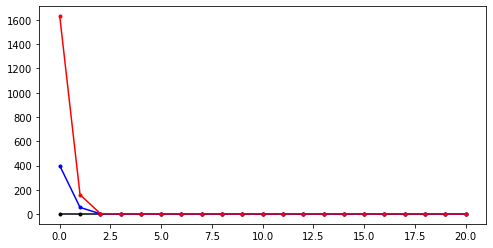

In [15]:
#
# Evolutionary Programming
# =======================================================================
#

#
# Parámetros
#
NGEN = 20
POPSIZE = 6

#
# Operadores genéticos
# =======================================================================
#

# Poblacion inicial
generate_population = RandomPopulation(
    pop_size=POPSIZE,
    low=[-2.048, -1.0, -5.0],
    high=[2.048, +4.0, +5.0],
    sigmas=0.1,
)

# Clonación
clone = Clone()

# Mutación
mutate = MutateGaussianEP(alpha=0.2, sigma_min=0.1, sigma_max=4.0)

# Evaluación de la función objetivo
fn_eval = FnEval(fn)

# selección de la siguiente generacion
selection = SelectionBest(k=POPSIZE)


#
# Algoritmo
# =======================================================================
#

# Se genera la población inicial
population = generate_population()

# Se evalua la función objetivo de la
# población inicial
population = fn_eval(population)

# historia
history = {"max": [], "min": [], "mean": []}

# ordena la poblacion
population = selection(population)

# Computa las estadísiticas de la población
history = compute_history(history, population)


for _ in range(NGEN):

    offsprings = clone(population)

    offsprings = mutate(offsprings)

    offsprings = fn_eval(offsprings)

    population = population + offsprings

    population = selection(population)

    history = compute_history(history, population)


plt.figure(figsize=(8, 4))
plt.plot(history["min"], ".-k")
plt.plot(history["mean"], ".-b")
plt.plot(history["max"], ".-r")
plt.show()

In [16]:
population

[{'x': array([-0.48012043,  0.27506428, -2.97706753]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.1, 0.1, 0.1])},
 {'x': array([-0.31620249,  0.28027293, -2.83641635]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.13988336, 0.13988336, 0.13988336])},
 {'x': array([-0.45777615,  0.09777127, -2.84209153]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.14794465, 0.14794465, 0.14794465])},
 {'x': array([ 0.3580612 , -0.19433486, -2.86244039]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.26137628, 0.26137628, 0.26137628])},
 {'x': array([-0.85833113,  0.16925529, -3.10061874]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.16580268, 0.16580268, 0.16580268])},
 {'x': array([-0.68833054,  0.40412802, -2.76028774]),
  'fn_x': 2.389214718082907,
  'sigmas': array([0.1922265, 0.1922265, 0.1922265])}]